In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer

In [118]:
train_df = pd.read_csv('./input/train.csv', usecols=['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
test_df = pd.read_csv('./input/test.csv', usecols=['id', 'comment_text'])

# Rename columns in the DataFrame
columns_base = ['ID', 'Comment_Text']
columns_type = ['Is_Toxic', 'Is_Severe_Toxic', 'Is_Obscene', 'Is_Threat', 'Is_Insult', 'Is_Identity_Hate']
columns_all = columns_base + columns_type
train_df.columns = columns_all
test_df.columns = columns_base

In [192]:
# CONSTANTS
LINEAR_REGRESSION = 'LinearRegression'
RANDOM_FORREST = 'RandomForrest'
MODEL = LINEAR_REGRESSION
NUM_OF_ROWS = 10_000
RANDOM_SAMPLE = False
USE_TEST_DATASET = False
RUN_FULL_PCA = False

# EDA

In [120]:
train_df.head(5)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [121]:
type_count = train_df[columns_type].sum()
total_samples = len(train_df)
type_percentage = (type_count / total_samples) * 100
print("Size of train dataset:")
print(train_df.shape)

rows_with_all_zeros = train_df[(train_df[columns_type] == 0).all(axis=1)]
print("\nCount of rows with all 0 types:", len(rows_with_all_zeros))

percentage_nonzero_types = 1 - (len(rows_with_all_zeros) / len(train_df))
print("\nPercentage of rows with at least one non-zero type: {:.2%}".format(percentage_nonzero_types))

class_summary = pd.DataFrame({'Count': type_count, 'Percentage': type_percentage})
class_summary['Percentage'] = class_summary['Percentage'].map('{:.2f}%'.format)
print("\nSum for each type with added value, percentage and labels:")
print(class_summary)

Size of train dataset:
(159571, 8)

Count of rows with all 0 types: 143346

Percentage of rows with at least one non-zero type: 10.17%

Sum for each type with added value, percentage and labels:
                  Count Percentage
Is_Toxic          15294      9.58%
Is_Severe_Toxic    1595      1.00%
Is_Obscene         8449      5.29%
Is_Threat           478      0.30%
Is_Insult          7877      4.94%
Is_Identity_Hate   1405      0.88%


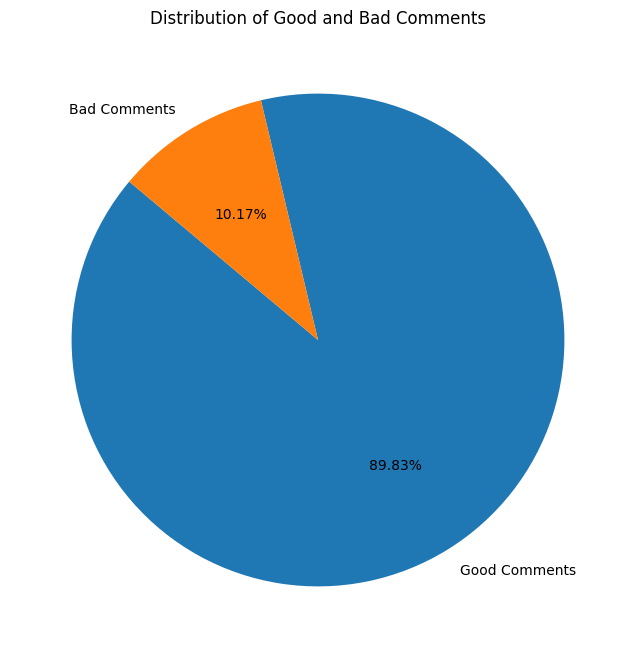

In [122]:
comments_category = pd.DataFrame({
    'Category': ['Good Comments', 'Bad Comments'],
    'Count': [len(rows_with_all_zeros), len(train_df) - len(rows_with_all_zeros)]
})

plt.figure(figsize=(8, 8))
plt.pie(comments_category['Count'], labels=comments_category['Category'], autopct='%1.2f%%', startangle=140)
plt.title('Distribution of Good and Bad Comments')
plt.show()

In [123]:
selected_rows_df = pd.DataFrame(columns=columns_all)
type_counts = {}
for text_type in columns_type:
    mask = (train_df[text_type] == 1) & (train_df[columns_type].sum(axis=1) == 1)
    count = mask.sum()
    type_counts[text_type] = count
    first_appearance = train_df[mask].head(1)
    selected_rows_df = pd.concat([selected_rows_df, first_appearance], ignore_index=True)

print("Count of comments where only a specific type has 1 and others are 0:")
for text_type, count in type_counts.items():
    print(f"{text_type}: {count}")

Count of comments where only a specific type has 1 and others are 0:
Is_Toxic: 5666
Is_Severe_Toxic: 0
Is_Obscene: 317
Is_Threat: 22
Is_Insult: 301
Is_Identity_Hate: 54


In [124]:
selected_rows_df = pd.DataFrame(columns=columns_all)
for text_type in columns_type:
    mask = (train_df[text_type] == 1) & (train_df[columns_type].sum(axis=1) == 1)
    first_appearance = train_df[mask].head(1)
    selected_rows_df = pd.concat([selected_rows_df, first_appearance], ignore_index=True)

In [125]:
with pd.option_context('display.max_colwidth', None):
  display(selected_rows_df)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,0005c987bdfc9d4b,"Hey... what is it..\n@ | talk .\nWhat is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?\n\nAsk Sityush to clean up his behavior than issue me nonsensical warnings...",1,0,0,0,0,0
1,01625cc84c6ef15b,"How do you know he is dead. Its just his plane that crashed. Jeezz, quit busting his nuts, folks.",0,0,1,0,0,0
2,09eb7d87b8c24ca5,"Please stop. If you continue to ignore our policies by introducing inappropriate pages to Wikipedia, you will be blocked.",0,0,0,1,0,0
3,006d11791d76b9f3,"REPLY ABOVE:\nThat was me, loser. The UN defines Vietnam to be part of Southeast Asia. And far as I know Vietnam is part of ASEAN, and used to be part of French Indochina with Laos and all those shit countries Anyway your culture has always been more influenced by SEA than Han Chinese (as in proper Yangtze Han Chinese, not the fringe indigenous tribes in Guangzhou/Guangxi). \n\nJust admit that you vietnamese are all a bunch of wannabe crap people. ALL the east asian people I've spoken to thinks of Vietnam as a very integral part of SEA, and we all think you're backward, dirty and speak in a horrible swearing language. Doesn't matter what crap you spout on Wikipedia, won't change the way people in the real world think.",0,0,0,0,1,0
4,09b51ed1ee5e29a1,"Mate, sound like you are jewish\n\nGayness is in the air",0,0,0,0,0,1


In [126]:
sample_stats = train_df.copy()

# Calculate and display number of words, characters, symbols, and capital letters separately for the original comment text
columns_stats = ['num_words', 'num_chars', 'num_symbols', 'num_capital_letters']
sample_stats['num_words'] = sample_stats['Comment_Text'].apply(lambda x: len(str(x).split()))
sample_stats['num_chars'] = sample_stats['Comment_Text'].apply(len)
sample_stats['num_symbols'] = sample_stats['Comment_Text'].apply(
    lambda x: len([char for char in str(x) if not char.isalnum() and not char.isspace()]))
sample_stats['num_capital_letters'] = sample_stats['Comment_Text'].apply(
    lambda x: sum(1 for char in str(x) if char.isupper()))

In [127]:
def show_stats(columns_name):
    mean = np.mean(sample_stats[columns_name])
    median = np.median(sample_stats[columns_name])
    std_dev = np.std(sample_stats[columns_name])
    min_value = np.min(sample_stats[columns_name])
    max_value = np.max(sample_stats[columns_name])
    
    print("Mean:", mean)
    print("Median:", median)
    print("Standard Deviation:", std_dev)
    print("Minimum Value:", min_value)
    print("Maximum Value:", max_value)

Number of Words stats:

Mean: 67.27352714465661
Median: 36.0
Standard Deviation: 99.23039126279367
Minimum Value: 1
Maximum Value: 1411


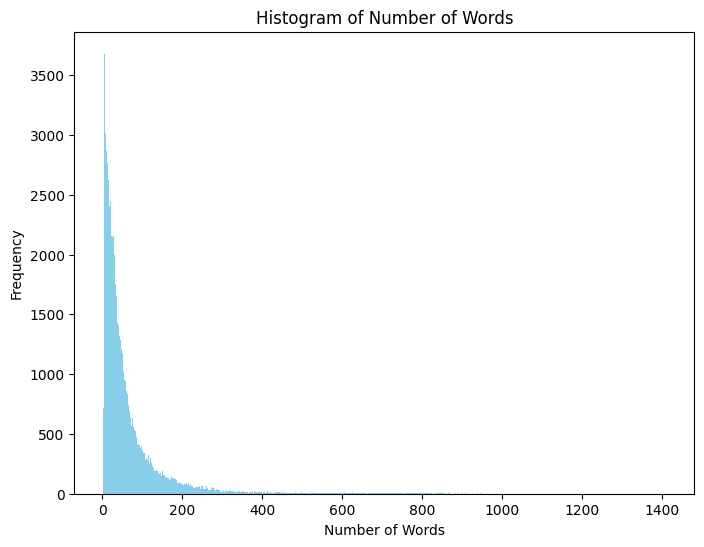

In [128]:
# Create and display a histogram for the number of words
plt.figure(figsize=(8, 6))
plt.hist(sample_stats['num_words'], bins=range(min(sample_stats['num_words']), max(sample_stats['num_words']) + 1), edgecolor='black', color="skyblue", lw=0)
plt.title('Histogram of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

print("Number of Words stats:\n")
show_stats('num_words')

plt.show()

Number of Characters stats:

Mean: 394.0732213246768
Median: 205.0
Standard Deviation: 590.7184309382144
Minimum Value: 6
Maximum Value: 5000


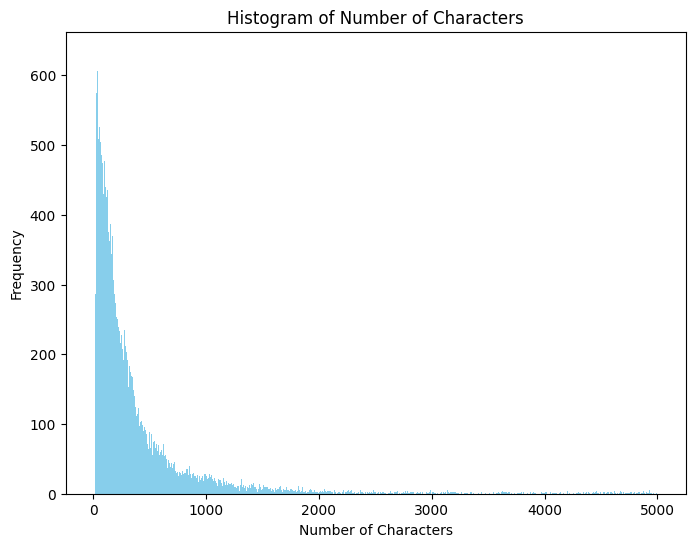

In [129]:
# Create and display a histogram for the number of characters
plt.figure(figsize=(8, 6))
plt.hist(sample_stats['num_chars'], bins=range(min(sample_stats['num_chars']), max(sample_stats['num_chars']) + 1), edgecolor='black', color="skyblue", lw=0)
plt.title('Histogram of Number of Characters')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')

print("Number of Characters stats:\n")
show_stats('num_chars')

plt.show()

Number of Symbols stats:

Mean: 16.105940302435908
Median: 8.0
Standard Deviation: 36.997153498413226
Minimum Value: 0
Maximum Value: 4942


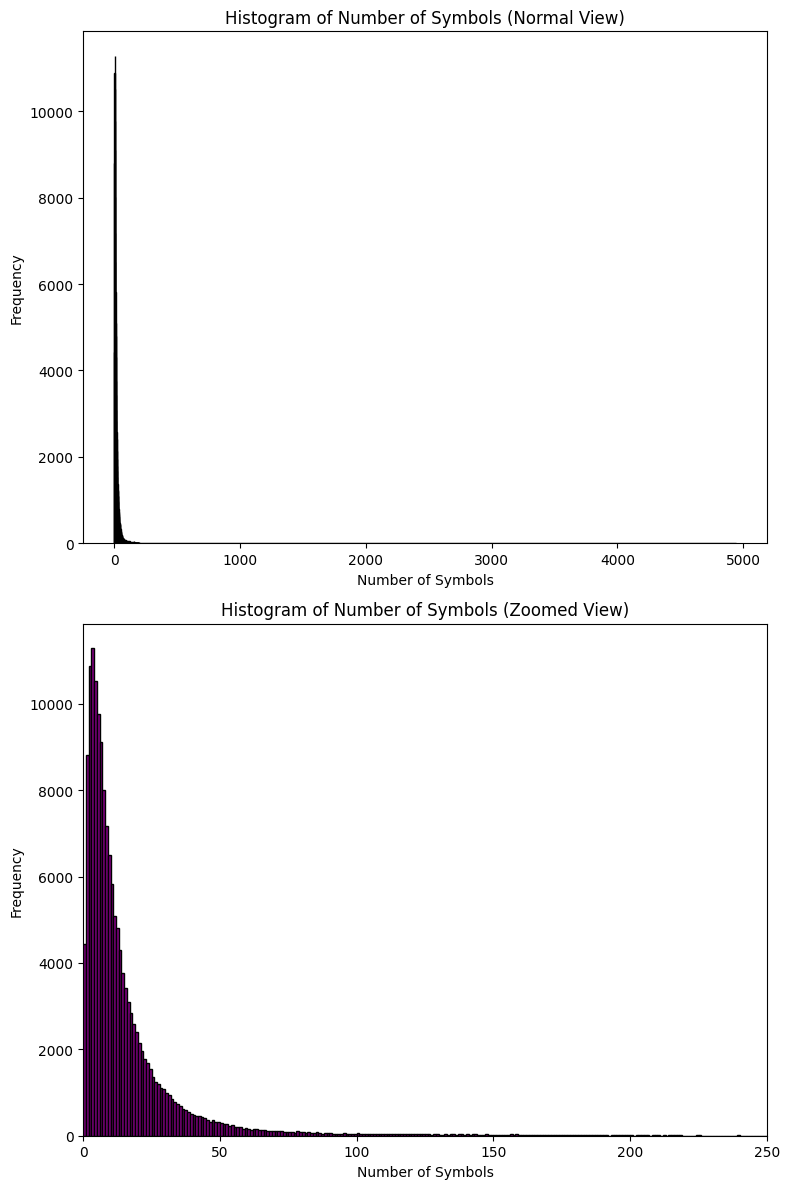

In [130]:
# Create and display a histogram for the number of symbols
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot 1: Normal view
axes[0].hist(sample_stats['num_symbols'], bins=range(min(sample_stats['num_symbols']), max(sample_stats['num_symbols']) + 1), color='purple', edgecolor='black')
axes[0].set_title('Histogram of Number of Symbols (Normal View)')
axes[0].set_xlabel('Number of Symbols')
axes[0].set_ylabel('Frequency')

# Plot 2: Zoomed-in x-axis
axes[1].hist(sample_stats['num_symbols'], bins=range(min(sample_stats['num_symbols']), max(sample_stats['num_symbols']) + 1), color='purple', edgecolor='black')
axes[1].set_title('Histogram of Number of Symbols (Zoomed View)')
axes[1].set_xlabel('Number of Symbols')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(left=0, right=250)

print("Number of Symbols stats:\n")
show_stats('num_symbols')

plt.tight_layout()
plt.show()

Number of Capital Letters stats:

Mean: 17.159628002581922
Median: 7.0
Standard Deviation: 96.52780102704632
Minimum Value: 0
Maximum Value: 4960


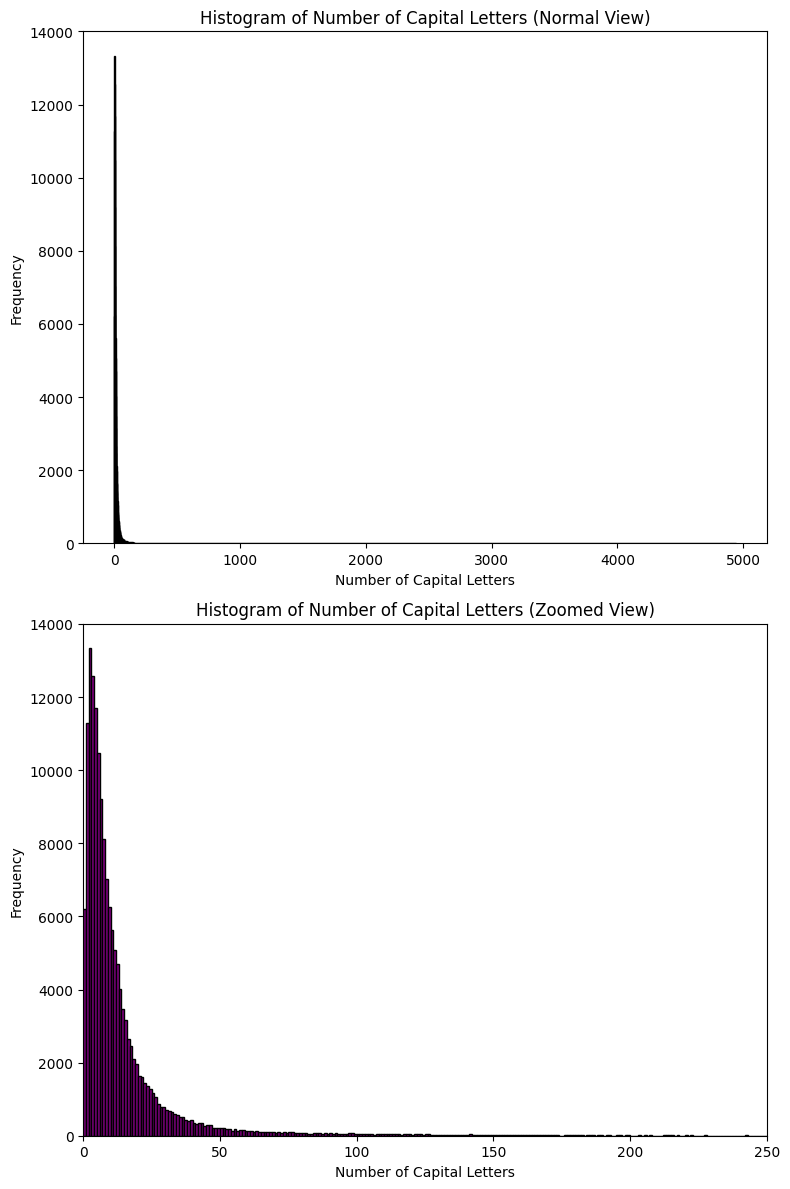

In [131]:
# Create and display a histogram for the number of capital letters
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))

# Plot 1: Normal view
axes[0].hist(sample_stats['num_capital_letters'], bins=range(min(sample_stats['num_symbols']), max(sample_stats['num_symbols']) + 1), color='purple', edgecolor='black')
axes[0].set_title('Histogram of Number of Capital Letters (Normal View)')
axes[0].set_xlabel('Number of Capital Letters')
axes[0].set_ylabel('Frequency')

# Plot 2: Zoomed-in x-axis
axes[1].hist(sample_stats['num_capital_letters'], bins=range(min(sample_stats['num_symbols']), max(sample_stats['num_symbols']) + 1), color='purple', edgecolor='black')
axes[1].set_title('Histogram of Number of Capital Letters (Zoomed View)')
axes[1].set_xlabel('Number of Capital Letters')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(left=0, right=250)

print("Number of Capital Letters stats:\n")
show_stats('num_capital_letters')

plt.tight_layout()
plt.show()

In [132]:
correlation_matrix = sample_stats[columns_type + columns_stats].corr()
correlation_matrix

,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
Is_Toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009,-0.052444,-0.054470,-0.014582,0.091175
Is_Severe_Toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600,0.008452,0.010131,0.037277,0.143410
Is_Obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867,-0.042207,-0.042945,-0.014460,0.081691
Is_Threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128,-0.006688,-0.008011,0.017213,0.033581
Is_Insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736,-0.043642,-0.045052,-0.016584,0.075945
Is_Identity_Hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000,-0.014493,-0.013647,-0.010848,0.053576
num_words,-0.052444,0.008452,-0.042207,-0.006688,-0.043642,-0.014493,1.000000,0.987839,0.575850,0.358341
num_chars,-0.054470,0.010131,-0.042945,-0.008011,-0.045052,-0.013647,0.987839,1.000000,0.629901,0.370550
num_symbols,-0.014582,0.037277,-0.014460,0.017213,-0.016584,-0.010848,0.575850,0.629901,1.000000,0.254003
num_capital_letters,0.091175,0.143410,0.081691,0.033581,0.075945,0.053576,0.358341,0.370550,0.254003,1.000000


In [133]:
sample_stats.sort_values(by='num_capital_letters', ascending=False).head(10)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
11796,1f31848ca28571da,==U R GAY== \n\nFUCKFUCKFUCKFUCKFUCKFUCKFUCKFU...,1,1,1,0,1,1,4,4969,4,4960
40851,6d063d8888c30ce7,Discussion destroying CRAP topic \n\nIt seems ...,1,0,0,0,0,0,52,4957,5,4717
6201,1091689382892a88,SECURITYFUCK HOMELAND SECURITYFUCK HOMELAND SE...,1,1,1,0,0,0,455,5000,0,4546
1876,0512b588a4b80e45,YOUR ARE FUCKING GAY WAD!!!!!!!!!!!!!!!!!!!!!!...,1,0,1,0,1,1,96,4897,200,4522
128196,ad9af3006c7cbbe6,toolLONG LIVE ANONYMOUS PHILIPPINESLONG LIVE A...,0,0,0,0,0,0,484,4999,0,4512
35316,5e50cf56f160bda3,MarxismLONG LIVE ANONYMOUS PHILIPPINESLONG LIV...,0,0,0,0,0,0,484,5000,0,4511
121718,8b31f2d7d6025482,BUTTSECKS BUTTSECKS BUTTSECKS BUTTSECKS BUTTSE...,1,0,1,0,0,0,497,5000,0,4473
82636,dd0bd64b02c550af,"MUAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHAHA, YOU C...",1,0,0,0,0,0,433,5000,144,4424
63687,aa699b024b46da4a,do you know what i say gas the mother fucking ...,1,1,1,0,0,1,608,4969,0,4320
42061,70368dd072aebb42,WANKER WANKER WANKER WANKER WANKER WANKER WANK...,1,0,0,0,0,0,715,5000,0,4286


In [134]:
sample_stats.sort_values(by='num_symbols', ascending=False).head(10)

,ID,Comment_Text,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate,num_words,num_chars,num_symbols,num_capital_letters
75499,c9f42b4dedc3cbf0,YOU!\nYou blocked me worm why!!!!!!!!!!!!!!!!!...,1,0,0,0,0,0,7,4970,4942,4
135857,d6ab1b62b0d08a2e,why don't you suck my ass until your lips blee...,1,1,1,0,1,0,30,4969,4819,80
52727,8cee04ab6861a675,I'M GONNA KILL YOU!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,1,0,1,0,0,100,4969,4518,350
40485,6c0b6e54d0b2ca24,LUNCHABLES!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!...,1,0,0,0,0,0,164,4681,3260,530
86529,e77118621b13b43f,Wikipedia tEh Free Enyclopedia!!!!!!!!!!!!!!!!...,0,0,0,0,0,0,280,5000,2762,280
31042,52791a0d0a4ba563,Is weezer okay?Is weezer okay?Is weezer okay?I...,0,0,0,0,0,0,311,4384,2210,155
28855,4c7963eaf9697d35,JIM WALES MUST DIE!!!!!!!!!!!! JIM WALES MUST...,1,1,0,1,0,0,626,5000,1872,2347
112812,5b7bd7b09b7ba86c,IDIOT/////IDIOT/////IDIOT/////IDIOT/////IDIOT/...,1,1,1,0,1,0,5,2680,1330,1345
67761,b54951588a1207ea,"This signature from, (Mr. Geroge W. Bush)\n\n...",0,0,0,0,0,0,185,2357,1269,59
139496,eaac752ae552d44a,'''[[\n== [[\n[[== THIS SITE IS STUPID DON'T T...,1,0,0,0,1,0,13,1308,1269,27


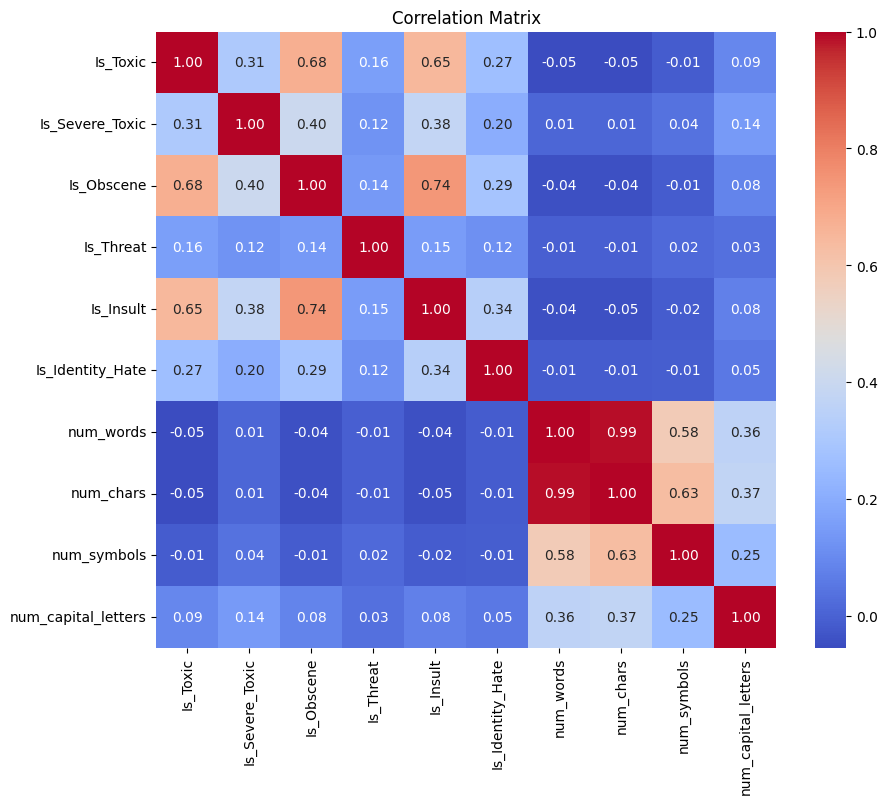

In [135]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Preprocessing

In [184]:
# Filter all hate comments for model training
hate_comments_df = train_df[train_df[columns_type].any(axis=1)].copy().reset_index(drop=True)
print(f"Hate comments size: {len(hate_comments_df)}")

# Filter the same amount of good comments for model training
good_comments_df = train_df[train_df[columns_type].eq(0).all(axis=1)].sample(n=len(hate_comments_df),random_state=42).copy().reset_index(drop=True)
print(f"Good comments size: {len(good_comments_df)}")

# Concatenate 50% hate and 50% good comments and shuffle
train_df_copy = pd.concat([hate_comments_df, good_comments_df], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print(f"Final dataset size: {train_df_copy.shape}")

Hate comments size: 16225
Good comments size: 16225
Final dataset size: (32450, 8)


In [138]:
from preprocessing import do_preprocessing

train_df_copy['Comment_Text_Preprocessed'] = train_df_copy["Comment_Text"].apply(lambda d: " ".join(do_preprocessing(d)))

In [139]:
X = train_df_copy['Comment_Text_Preprocessed']
y = train_df_copy[columns_type]

tfidf_vectorizer = TfidfVectorizer(max_features=10_000, max_df=0.9, smooth_idf=True, use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [140]:
# Save tfidf_vectorizer
joblib.dump(tfidf_vectorizer, './models/tfidf_vectorizer.joblib')

# Load tfidf_vectorizer
# tfidf_vectorizer = joblib.load('./models/tfidf_vectorizer.joblib')

['./models/tfidf_vectorizer.joblib']

In [141]:
train_df_copy_tfidf = pd.concat([train_df_copy, tfidf_df], axis=1)
print(train_df_copy.shape)
print(train_df_copy_tfidf.shape)
print(f"Unique words count: {len(feature_names)}")

(32450, 9)
(32450, 10009)
Unique words count: 10000


In [142]:
# Display the top 100 most popular words
top_100_words = tfidf_df.sum().sort_values(ascending=False).head(100)
print(top_100_words.to_string())

page           692.924699
article        678.204139
fuck           671.113335
dont           547.153642
like           518.363000
wikipedia      511.785568
talk           502.705823
please         438.847282
im             413.407988
get            402.067972
one            387.582017
know           387.337746
fucking        387.246232
go             379.367909
would          352.336686
think          349.956022
people         330.671096
youre          322.856024
edit           318.450926
see            316.808265
stop           311.825248
shit           289.922141
thanks         289.652016
time           287.859909
source         273.942848
user           272.073539
want           270.928885
make           267.508887
suck           261.780384
also           261.304153
say            245.001130
good           237.291138
need           234.533768
bitch          228.011434
look           227.014515
comment        226.144652
stupid         223.762115
block          223.748967
well        

In [143]:
# Check for any non numeric values in the features dataframe
tfidf_features = train_df_copy_tfidf[feature_names]
numeric_df = tfidf_features.apply(pd.to_numeric, errors='coerce')
nan_values = numeric_df.isna().sum().sum()

if nan_values == 0:
    print("All values in the DataFrame are numeric.")
else:
    print(f"There are {nan_values} non-numeric values in the DataFrame.")

All values in the DataFrame are numeric.


# PCA

In [144]:
from sklearn.decomposition import PCA

n_components = 2
pca_2 = PCA(n_components=n_components)
pca_result_2 = pca_2.fit_transform(tfidf_features)
pca_result_df_2 = pd.DataFrame(data=pca_result_2, columns=[f'PCA_{i + 1}' for i in range(n_components)])

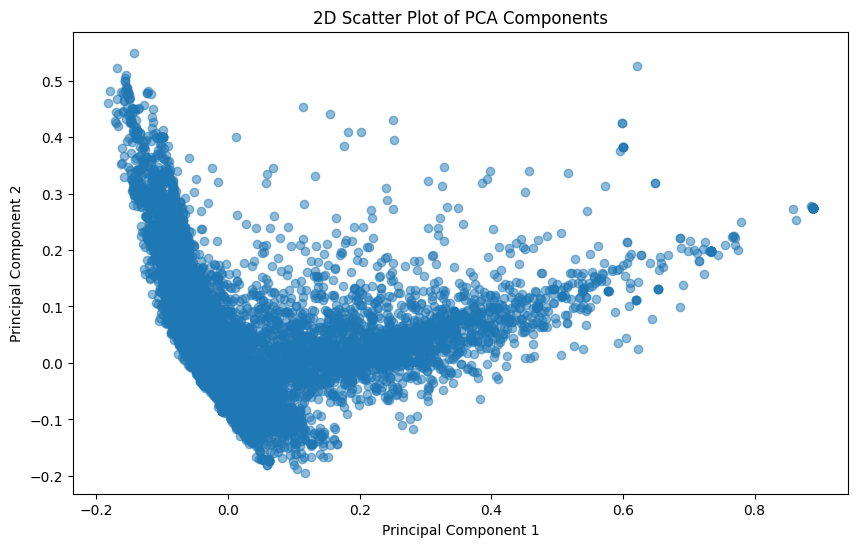

In [145]:
plt.figure(figsize=(10, 6))
plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], alpha=0.5)
plt.title('2D Scatter Plot of PCA Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [146]:
print(pca_2.explained_variance_ratio_)

[0.00877407 0.00613028]


In [147]:
n_components = 3
pca_3 = PCA(n_components=n_components)
pca_result_3 = pca_3.fit_transform(tfidf_features)

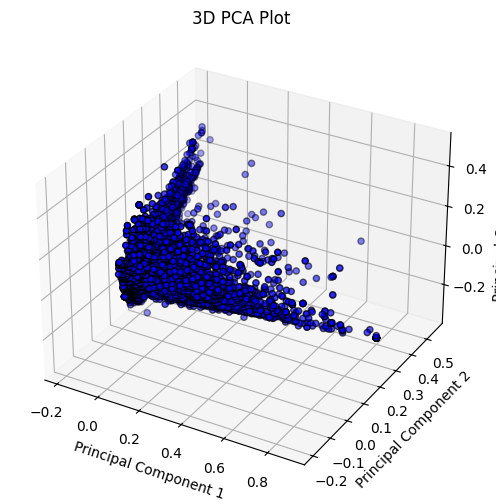

In [148]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result_3[:, 0], pca_result_3[:, 1], pca_result_3[:, 2], c='blue', marker='o', edgecolors='k')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Plot')
plt.show()

In [149]:
print(pca_3.explained_variance_ratio_)

[0.00877407 0.00613028 0.00446135]


In [150]:
# Calculate PCA with 0.95 explained variance
# pca = PCA(0.95)
# pca_result = pca.fit_transform(tfidf_features)
# exp_var_pca = pca.explained_variance_ratio_
# cum_sum_eigenvalues = np.cumsum(exp_var_pca)

In [151]:
# plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
# plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', label='Cumulative explained variance')
# plt.ylabel('Explained variance ratio')
# plt.xlabel('Principal component index')
# plt.legend(loc='best')
# plt.tight_layout()
# 
# print(f"Number of components for 0.95 explained variance: {len(cum_sum_eigenvalues)}")
# plt.show()

# Clustering

In [152]:
from sklearn.cluster import KMeans
n_clusters = 7

# Apply KMeans on UMAP data
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_result_2)
labels = kmeans_pca_labels

Number of clusters: 7
Cluster 0: 1298 points
Cluster 1: 3918 points
Cluster 2: 10053 points
Cluster 3: 728 points
Cluster 4: 165 points
Cluster 5: 949 points
Cluster 6: 15339 points


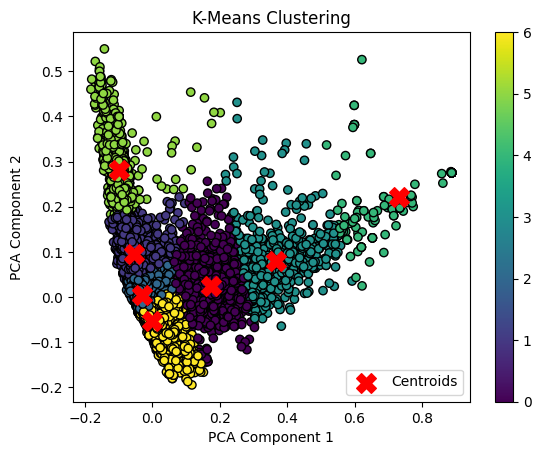

In [153]:
# Visualize the clustering results
scatter = plt.scatter(pca_result_2[:, 0], pca_result_2[:, 1], c=kmeans_pca_labels, cmap='viridis', marker='o', edgecolors='k')
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c='red', marker='X',label='Centroids')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering')
plt.legend()

unique_labels = set(labels)
print("Number of clusters:", len(unique_labels) - (1 if -1 in unique_labels else 0))
for cluster_label in unique_labels:
    if cluster_label == -1:
        print(f"Noise points: {sum(labels == cluster_label)}")
    else:
        print(f"Cluster {cluster_label}: {sum(labels == cluster_label)} points")

plt.colorbar(scatter)
plt.show()

# Model Training

In [154]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, hamming_loss

In [155]:
X.head()

0                                old cougar old cougar
1                        im scared brrrr im gon na die
2    okay anal sex widely unaccepted disgusting evi...
3    shut cunt wwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwww...
4       arrogant administrator homosexual bastard fuck
Name: Comment_Text_Preprocessed, dtype: object

In [156]:
y.head()

,Is_Toxic,Is_Severe_Toxic,Is_Obscene,Is_Threat,Is_Insult,Is_Identity_Hate
0,1,0,0,0,1,0
1,0,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,1,0,1,0
4,1,1,1,0,1,1


In [157]:
class_labels = ['Toxic', 'Severe_Toxic', 'Obscene', 'Threat', 'Insult', 'Identity_Hate']

In [158]:
# Split Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [159]:
X_test_tfidf.shape

(6490, 10000)

In [193]:
if MODEL == LINEAR_REGRESSION:
    lr = LogisticRegression(max_iter=1000)
    clf = MultiOutputClassifier(lr)
    clf = clf.fit(X_train_tfidf, y_train)

In [161]:
if MODEL == LINEAR_REGRESSION:
    # Save model
    joblib.dump(clf, './models/linear_regression_classifier_model.joblib')
    # Load model
    # clf = joblib.load('./models/linear_regression_classifier_model.joblib')

In [162]:
# Get the class labels for each classifier
# for i, estimator in enumerate(clf.estimators_):
#     print(f"Classifier {i + 1} Class Labels:", estimator.classes_)

In [194]:
if MODEL == LINEAR_REGRESSION:
    prediction = clf.predict(X_test_tfidf)
    print('Accuracy Score: ', round(accuracy_score(y_test, prediction), 3))
    print('Hamming Loss: ', round(hamming_loss(y_test, prediction), 3))

Accuracy Score:  0.663
Hamming Loss:  0.078


In [198]:
if MODEL == LINEAR_REGRESSION:
    sample_text = ["some not very toxic toxic toxic text"]
    sample_text_tfidf = tfidf_vectorizer.transform(sample_text)
    sample_text_pred_prob = clf.predict_proba(sample_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = sample_text_pred_prob[i][:, 1]

In [200]:
if MODEL == LINEAR_REGRESSION:
    print(prediction_df)

      Toxic  Severe_Toxic   Obscene    Threat    Insult  Identity_Hate
0  0.285991       0.02067  0.118829  0.008197  0.102635       0.021546


In [201]:
if MODEL == RANDOM_FORREST:
    base_classifier = RandomForestClassifier(random_state=42)
    multi_output_classifier = MultiOutputClassifier(base_classifier)
    multi_output_classifier = multi_output_classifier.fit(X_train_tfidf, y_train)

In [202]:
if MODEL == RANDOM_FORREST:
    # Save model
    joblib.dump(multi_output_classifier, './models/random_forrest_classifier_model.joblib')
    # Load model
    # multi_output_classifier = joblib.load('./models/random_forrest_classifier_model.joblib')

In [203]:
# Evaluate the model
if MODEL == RANDOM_FORREST:
    y_pred = multi_output_classifier.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_report_str)

Accuracy: 0.639753466872111
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      3100
           1       0.30      0.04      0.07       311
           2       0.86      0.77      0.81      1652
           3       0.77      0.09      0.17       106
           4       0.74      0.61      0.67      1550
           5       0.63      0.21      0.31       293

   micro avg       0.84      0.68      0.75      7012
   macro avg       0.70      0.42      0.48      7012
weighted avg       0.81      0.68      0.73      7012
 samples avg       0.35      0.33      0.33      7012


C:\Users\vnaky\PycharmProjects\naukma_ml_hw4\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vnaky\PycharmProjects\naukma_ml_hw4\venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [205]:
if MODEL == RANDOM_FORREST:
    prediction_probabilities = multi_output_classifier.predict_proba(X_test_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = prediction_probabilities[i][:, 1]

In [206]:
if MODEL == RANDOM_FORREST:
    print(prediction_df.head())

      Toxic  Severe_Toxic   Obscene  Threat    Insult  Identity_Hate
0  1.000000      0.158024  0.990000    0.00  0.910000       0.380000
1  0.780000      0.100000  0.603333    0.01  0.570000       0.090000
2  0.370000      0.000000  0.030000    0.02  0.020000       0.070000
3  0.099287      0.000130  0.042059    0.00  0.044141       0.000707
4  0.900000      0.110000  0.840000    0.03  0.613333       0.060000


In [207]:
if MODEL == RANDOM_FORREST:
    sample_text = ["some toxic text"]
    sample_text_tfidf = tfidf_vectorizer.transform(sample_text)
    sample_text_pred_prob = multi_output_classifier.predict_proba(sample_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = sample_text_pred_prob[i][:, 1]

In [208]:
if MODEL == RANDOM_FORREST:
    print(prediction_df)

      Toxic  Severe_Toxic  Obscene  Threat    Insult  Identity_Hate
0  0.112715      0.000984  0.10756     0.0  0.009571       0.001424


# Prediction

In [175]:
columns_submission = ['id','toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [176]:
test_df.head()

,ID,Comment_Text
0,0001ea8717f6de06,Thank you for understanding. I think very high...
1,000247e83dcc1211,:Dear god this site is horrible.
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l..."


In [177]:
# Good comment
test_df.loc[test_df['ID'] == '00177176f33f587e']

,ID,Comment_Text
28,00177176f33f587e,== Can you work your magic? == \n\n Hi. I was...


In [178]:
# Bad comment
test_df.loc[test_df['ID'] == '0013fed3aeae76b7']

,ID,Comment_Text
24,0013fed3aeae76b7,DJ Robinson is gay as hell! he sucks his dick ...


In [179]:
test_text_tfidf = tfidf_vectorizer.transform(test_df['Comment_Text'])

In [180]:
if MODEL == LINEAR_REGRESSION:
    test_text_tfidf_prob = clf.predict_proba(test_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = test_text_tfidf_prob[i][:, 1]

In [181]:
if MODEL == LINEAR_REGRESSION:
    result_df = pd.concat([test_df['ID'], prediction_df], axis=1)
    result_df.columns = columns_submission
    result_df.to_csv('./output/submission.csv', index=False)
    result_df.head()

In [182]:
if MODEL == RANDOM_FORREST:
    test_text_tfidf_prob = multi_output_classifier.predict_proba(test_text_tfidf)
    prediction_df = pd.DataFrame()
    for i, output_name in enumerate(class_labels):
        prediction_df[output_name] = test_text_tfidf_prob[i][:, 1]

In [183]:
if MODEL == RANDOM_FORREST:
    result_df = pd.concat([test_df['ID'], prediction_df], axis=1)
    result_df.columns = columns_submission
    result_df.to_csv('./output/submission_random_forrest.csv', index=False)
    result_df.head()